In [1]:
# 2019/04/08
# Code to analyze 20190410-n34

In [2]:
import numpy as np
import pandas as pd
from uncertainties import unumpy, ufloat

import os
import glob

import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns

from lmfit.models import Model, ConstantModel, PolynomialModel, GaussianModel, VoigtModel, LorentzianModel, PseudoVoigtModel

sns.set_context('talk')

# Some constant variables

In [3]:
# List of files to glob
POL_LIST = glob.glob('n34_all_dimers-interleaved-Pol*_out.csv')
UNPOL_LIST = glob.glob('n34_all_dimers-interleaved-Unpol*_out.csv')

SET_NAME = '20190410-n34'
POL_NAME = '20190410-n34p'
UNPOL_NAME = '20190410-n34u'

ATOMIC = 1401.71
ZEEMAN = 1.60839
ORDER = -1

SATURATION_A = ufloat(44.0442405, 1.65366925)
SATURATION_B = ufloat(-0.05852900, 0.00456716)
NUM_EXPOSURES = 1000 # Number of excitation loops

# Retrieve files and do some preprocessing

### Retrieve all the data files and put in to a single DataFrame

In [4]:
# Last modified 2019/04/05
# Goes through all listed .csv files and returns data in a single DataFrame
def gather_data(file_list):
    
    # Read in .csv files in to single DataFrame
    out = pd.DataFrame()
    for file_name in file_list:
        df = pd.read_csv(file_name)
        df['Scan'] = os.path.basename(file_name)
        df['Timestamp'] = pd.to_datetime(df['Timestamp'])
        
        out = pd.concat([out, df], join='outer', ignore_index=True)
    
    return out

pol_data = gather_data(POL_LIST)
unpol_data = gather_data(UNPOL_LIST)

### Reduce the data by removing bad points

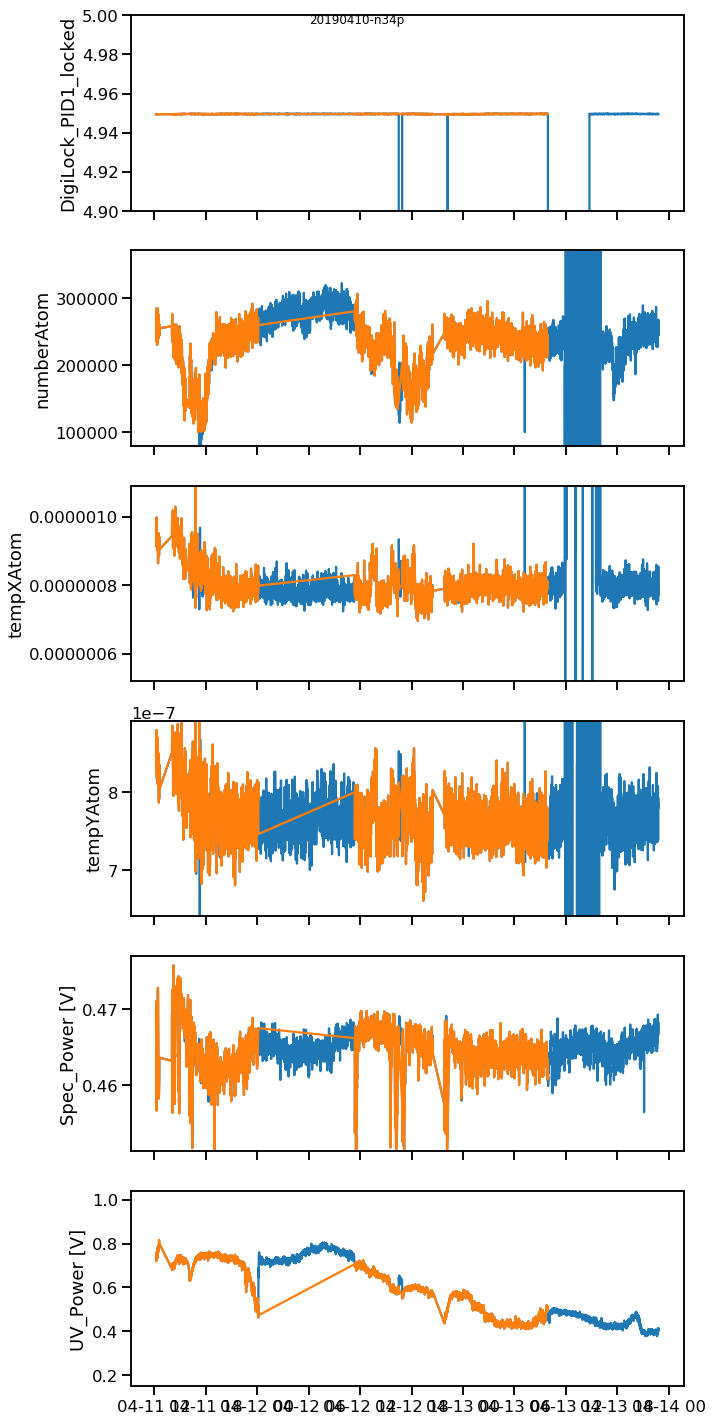

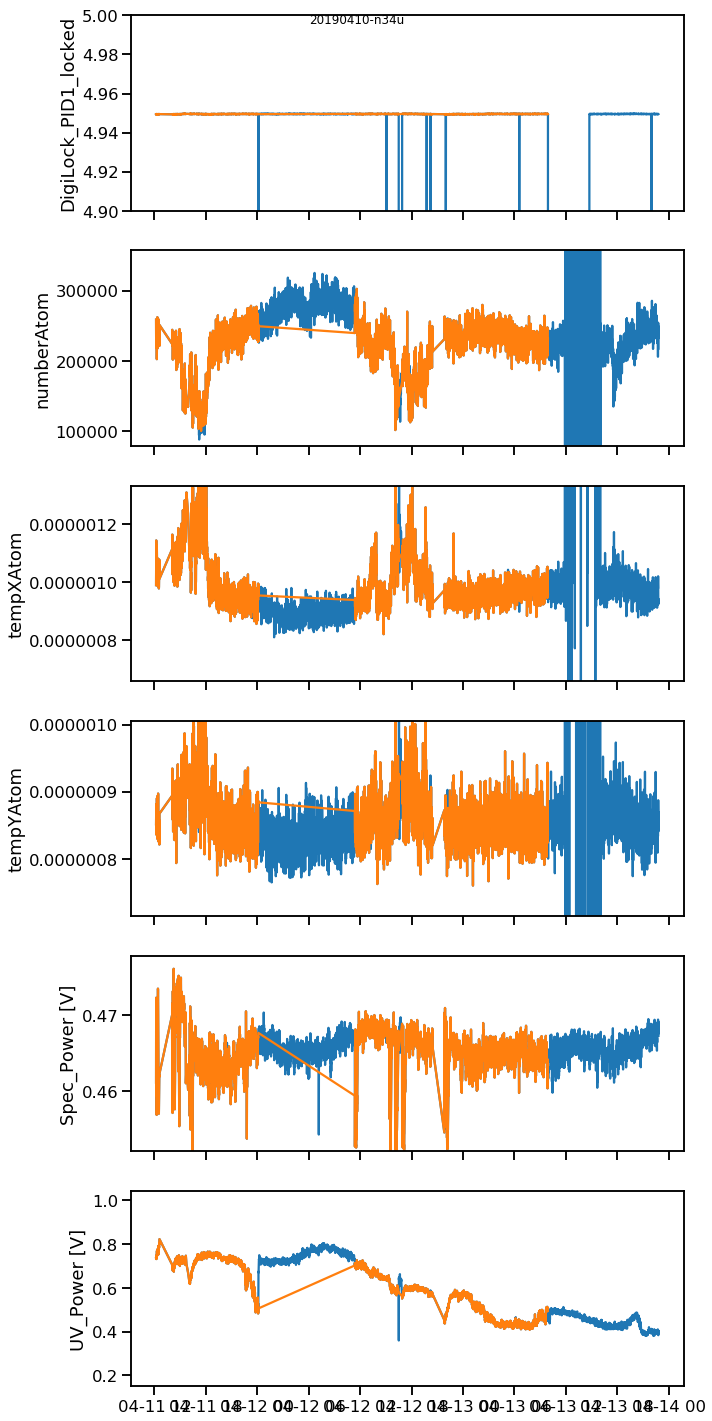

In [5]:
# First pass at removing bad data points
def reduce_data(df_data, name, show_plots):
    
    # Remove data where UV laser was not locked based on 'DigiLock_PID1_locked' column
    df_reduced = df_data[df_data['DigiLock_PID1_locked'] >= 4.9]
    
    # Remove data where 640 nm wavemeter reading was more than 0.001 /cm from 15655.424 /cm (the location of the line)
    df_reduced = df_reduced[(15655.423 <= df_reduced['wavemeterAtom']) & (df_reduced['wavemeterAtom'] <= 15655.425)]
    
    # Remove data where atom number was above/below cutoff
    df_reduced = df_reduced[(100e3 <= df_reduced['numberAtom']) & (df_reduced['numberAtom'] <= 400e3)]
    
    # Remove data where tempYAtom was above/below cutoff
    df_reduced = df_reduced[(500E-9 <= df_reduced['tempYAtom']) & (df_reduced['tempYAtom'] <= 1.2E-6)]
    
    # Plotting original and reduced data sets
    df_orig = df_data.sort_values(by=['Timestamp'])
    df_redu = df_reduced.sort_values(by=['Timestamp'])
    
    if show_plots:
        [fig, ax]= plt.subplots(nrows=6, ncols=1, figsize=(10,20), sharex=True, sharey=False)
        fig.suptitle(name)

        ax[0].set_ylabel('DigiLock_PID1_locked')
        ax[0].plot(df_orig['Timestamp'], df_orig['DigiLock_PID1_locked'])
        ax[0].plot(df_redu['Timestamp'], df_redu['DigiLock_PID1_locked'])
        ax[0].set_ylim((4.9, 5))

        ax[1].set_ylabel('numberAtom')
        ax[1].plot(df_orig['Timestamp'], df_orig['numberAtom'])
        ax[1].plot(df_redu['Timestamp'], df_redu['numberAtom'])
        avg = np.mean(df_redu['numberAtom'])
        std = np.std(df_redu['numberAtom'])
        ax[1].set_ylim((avg-4*std, avg+4*std))

        ax[2].set_ylabel('tempXAtom')
        ax[2].plot(df_orig['Timestamp'], df_orig['tempXAtom'])
        ax[2].plot(df_redu['Timestamp'], df_redu['tempXAtom'])
        avg = np.mean(df_redu['tempXAtom'])
        std = np.std(df_redu['tempXAtom'])
        ax[2].set_ylim((avg-4*std, avg+4*std))

        ax[3].set_ylabel('tempYAtom')
        ax[3].plot(df_orig['Timestamp'], df_orig['tempYAtom'])
        ax[3].plot(df_redu['Timestamp'], df_redu['tempYAtom'])
        avg = np.mean(df_redu['tempYAtom'])
        std = np.std(df_redu['tempYAtom'])
        ax[3].set_ylim((avg-4*std, avg+4*std))

        ax[4].set_ylabel('Spec_Power [V]')
        ax[4].plot(df_orig['Timestamp'], df_orig['Spec_Power'])
        ax[4].plot(df_redu['Timestamp'], df_redu['Spec_Power'])
        avg = np.mean(df_redu['Spec_Power'])
        std = np.std(df_redu['Spec_Power'])
        ax[4].set_ylim((avg-4*std, avg+4*std))

        ax[5].set_ylabel('UV_Power [V]')
        ax[5].plot(df_orig['Timestamp'], df_orig['UV_Power'])
        ax[5].plot(df_redu['Timestamp'], df_redu['UV_Power'])
        avg = np.mean(df_redu['UV_Power'])
        std = np.std(df_redu['UV_Power'])
        ax[5].set_ylim((avg-4*std, avg+4*std))

        plt.tight_layout()
        plt.show()
    
    # Drop unused data columns
    df_reduced.drop(columns=['AI3', 'AI4', 'AI5', 'AI6', 'AI7'], inplace=True)
    
    return df_reduced

pol_reduced = reduce_data(pol_data, POL_NAME, True)
unpol_reduced = reduce_data(unpol_data, UNPOL_NAME, True)

### Aggregrate data

In [6]:
def aggregrate_data(df_data, indVar):
    df_grouped = df_data.groupby(by=indVar, as_index=False, sort=True)
    
    #df_out = df_grouped.agg([np.mean, np.std])
    df_out = df_grouped.agg({'sfiIntegral': [np.mean, np.std],
                             'UV_Power': [np.mean, np.std],
                             'Spec_Power': [np.mean, np.std],
                             'numberAtom': [np.mean, np.std],
                             'tempXAtom':  [np.mean, np.std],
                             'tempYAtom':  [np.mean, np.std]})
    
    df_out['count'] = df_grouped.size().values
    return df_out

indVar = ['imagevcoAtom']

pol_out = aggregrate_data(pol_reduced, indVar)
unpol_out = aggregrate_data(unpol_reduced, indVar)

### Adjust counts due to MCP saturation

In [7]:
# Using the MCP saturation curve taken on 2019/03/27 by varying the UV power, we can account for the non-linear detection.

def mcp_saturation(df):
    df_temp = df
    observed_counts = unumpy.uarray(df_temp['sfiIntegral','mean'], df_temp['sfiIntegral','std'])
    observed_counts = observed_counts/NUM_EXPOSURES
    
    corrected_counts = -SATURATION_A*unumpy.log(1-observed_counts/SATURATION_A)
    corrected_counts = NUM_EXPOSURES*corrected_counts
    
    df_temp['sfiIntegral_linearized','mean'] = unumpy.nominal_values(corrected_counts)
    df_temp['sfiIntegral_linearized', 'std'] = unumpy.std_devs(corrected_counts)
    
    return df_temp

pol_out = mcp_saturation(pol_out)
unpol_out = mcp_saturation(unpol_out)

### Calculate detunings

In [8]:
def calc_detuning(df, atomic, zeeman, order):
    df['detuning'] = order*2*(df['imagevcoAtom'] - (atomic + order*zeeman))
    
    return df

pol_out = calc_detuning(pol_out, ATOMIC, ZEEMAN, ORDER)
unpol_out = calc_detuning(unpol_out, ATOMIC, 0, ORDER)

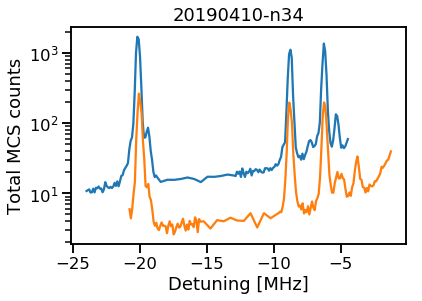

In [9]:
plt.figure()
plt.plot(pol_out['detuning'], pol_out['sfiIntegral_linearized']['mean'])
plt.plot(unpol_out['detuning'], unpol_out['sfiIntegral_linearized']['mean'])
plt.yscale('log')
plt.title(SET_NAME)
plt.xlabel('Detuning [MHz]')
plt.ylabel('Total MCS counts')
plt.show()

# Analyzing the data

In [10]:
pol_data = pol_out
unpol_data = unpol_out

### Adjust counts based on 689 nm and UV intensities

In [11]:
def adjust_for_intensities(df):
    df_temp = df
    
    raw_sfiIntegral = unumpy.uarray(df_temp['sfiIntegral_linearized', 'mean'], df_temp['sfiIntegral_linearized', 'std'])
    raw_UV_Power = unumpy.uarray(df_temp['UV_Power', 'mean'], df_temp['UV_Power', 'std'])
    raw_Spec_Power = unumpy.uarray(df_temp['Spec_Power', 'mean'], df_temp['Spec_Power', 'std'])
    
    adjusted_sfiIntegral = raw_sfiIntegral/raw_UV_Power/raw_Spec_Power
    
    df_temp['sfiIntegral_adjusted', 'mean'] = unumpy.nominal_values(adjusted_sfiIntegral)
    df_temp['sfiIntegral_adjusted', 'std'] = unumpy.std_devs(adjusted_sfiIntegral)
    
    return df_temp

# Correcting for 320 nm and 689 nm intensities point-by-point

pol_data = adjust_for_intensities(pol_data)
unpol_data = adjust_for_intensities(unpol_data)

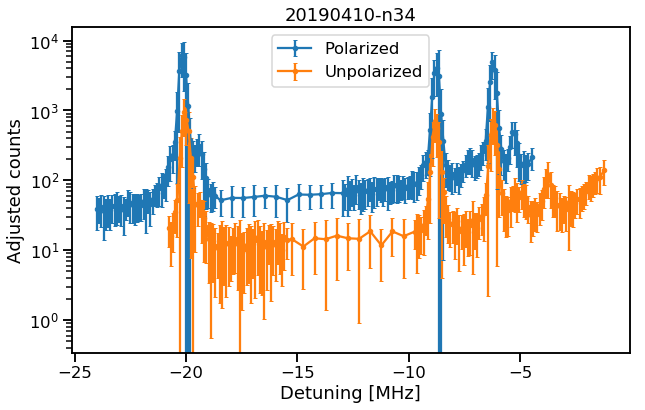

In [12]:
# Plotting results after adjusting for 320 nm and 689 nm powers

plt.figure(figsize=(10,6))
plt.errorbar(pol_data['detuning'], pol_data['sfiIntegral_adjusted', 'mean'], 
             yerr=pol_data['sfiIntegral_adjusted', 'std'],
             fmt='.-', capsize=2, label='Polarized')
plt.errorbar(unpol_data['detuning'], unpol_data['sfiIntegral_adjusted', 'mean'], 
             yerr=unpol_data['sfiIntegral_adjusted', 'std'],
             fmt='.-', capsize=2, label='Unpolarized')
plt.gca().set_yscale('log')
plt.title(SET_NAME)
plt.xlabel('Detuning [MHz]')
plt.ylabel('Adjusted counts')
plt.legend()
plt.show()

### 2019/07/16 - Saving spectra to excel file

In [13]:
# Flattening Pandas multiindex
# See: https://stackoverflow.com/questions/14507794/pandas-how-to-flatten-a-hierarchical-index-in-columns
pol_data_out = pol_data.copy(deep=True)
unpol_data_out = unpol_data.copy(deep=True)

pol_data_out.columns = [' '.join(col).strip() for col in pol_data_out.columns.values]
unpol_data_out.columns = [' '.join(col).strip() for col in unpol_data_out.columns.values]

with pd.ExcelWriter('20190410-n34-exp_spectra.xlsx') as writer:
    pol_data_out.to_excel(writer, sheet_name='polarized')
    unpol_data_out.to_excel(writer, sheet_name='unpolarized')

## Fitting the data

### n=34, polarized sample

#### n=34, polarized, dimer, ground state

[[Model]]
    ((Model(polynomial, prefix='bg_') + Model(pvoigt, prefix='d0_')) + Model(pvoigt, prefix='dx_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 280
    # data points      = 45
    # variables        = 9
    chi-square         = 143872.004
    reduced chi-square = 3996.44456
    Akaike info crit   = 381.150757
    Bayesian info crit = 397.410720
[[Variables]]
    bg_c0:         46.2584433 +/- 14.5066261 (31.36%) (init = 37.42806)
    d0_fraction:   0.17957237 +/- 0.06748532 (37.58%) (init = 0.5)
    d0_sigma:      0.15239226 +/- 0.00183646 (1.21%) (init = 0.1)
    d0_center:    -20.1537356 +/- 0.00128112 (0.01%) (init = -20.5)
    d0_amplitude:  2206.38341 +/- 55.9643536 (2.54%) (init = 1768)
    dx_fraction:   1.00000000 +/- 0.09838259 (9.84%) (init = 0.5)
    dx_sigma:      0.20686940 +/- 0.09797545 (47.36%) (init = 0.1)
    dx_center:    -19.4364040 +/- 0.05077697 (0.26%) (init = -19.5)
    dx_amplitude:  142.570503 +/- 67.0216639 (47.01%) (

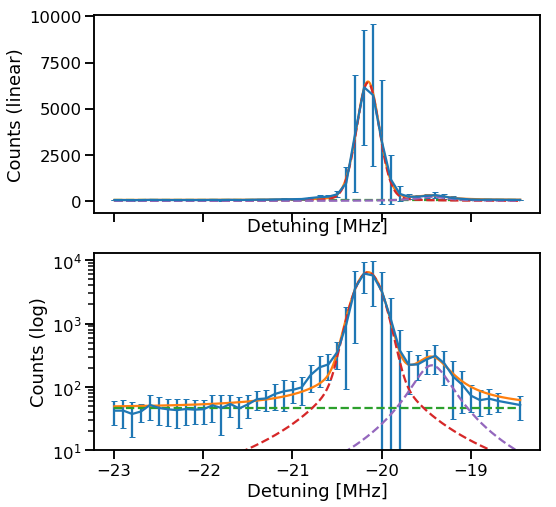

In [14]:
data = pol_data
plot_components = True
plot_initial_guess = False

# Choosing a range to fit over
xmin = -23
xmax = -18

xdata = data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['detuning']
ydata = data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['sfiIntegral_adjusted', 'mean']
ydata_unc = data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['sfiIntegral_adjusted', 'std']

# Specify fit model
bg = PolynomialModel(degree=0, prefix='bg_')
d0 = PseudoVoigtModel(prefix='d0_')
dx = PseudoVoigtModel(prefix='dx_')

fit_model = bg + d0 + dx
fit_params = fit_model.make_params()

fit_params['bg_c0'].set(min(ydata), vary=True)
#fit_params['bg_c1'].set(0, vary=True)
#fit_params['bg_c2'].set(0, vary=True)

fit_params['d0_center'].set(-20.5, vary=True)
fit_params['d0_amplitude'].set(1768, min=0, vary=True)
fit_params['d0_sigma'].set(0.1, min=0, vary=True)

fit_params['dx_center'].set(-19.5, vary=True)
fit_params['dx_amplitude'].set(43, min=0, vary=True)
fit_params['dx_sigma'].set(0.1, min=0, vary=True)

# Initial guess
xfit = np.linspace(min(xdata), max(xdata), num=1000, endpoint=True)
yinit = fit_model.eval(fit_params, x=xfit)

# Fitting
fit_result = fit_model.fit(ydata, fit_params, x=xdata)
dely = fit_result.eval_uncertainty(x=xdata)
yfit = fit_model.eval(fit_result.params, x=xfit)

print(fit_result.fit_report())

# Plotting output
[fig, axs] = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False, figsize=(8,8))

axs[0].errorbar(xdata, ydata, yerr=ydata_unc, capsize=3, label='data')
axs[0].plot(xfit, yfit, label='fit')
axs[0].set_xlabel('Detuning [MHz]')
axs[0].set_ylabel('Counts (linear)')

axs[1].set_yscale('log')
axs[1].errorbar(xdata, ydata, yerr=ydata_unc, capsize=3, label='data')
axs[1].plot(xfit, yfit, label='fit')
axs[1].set_xlabel('Detuning [MHz]')
axs[1].set_ylabel('Counts (log)')
axs[1].set_ylim(bottom=10)

if plot_components:
    # generate components
    fit_comps = fit_result.eval_components(x=xfit)
    
    for key in fit_comps.keys():
        for ax in axs:
            ax.plot(xfit, fit_comps[key], '--')

if plot_initial_guess:
    for ax in axs:
        ax.plot(xfit, yinit, '-.', label='init')

plt.show()

In [15]:
# Extracting the fitted parameters

labview_params = [('numberAtom', 'mean'), ('tempXAtom', 'mean'), ('tempYAtom', 'mean'), ('UV_Power', 'mean'), ('Spec_Power', 'mean')]

print('Xmin [MHz]:\t' + str(min(xdata)))
print('Xmax [MHz]:\t' + str(max(xdata)))
for p in labview_params:
    print(p[0] + '(mean):\t' + str(np.mean(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)][p])))
    print(p[0] + '(std):\t' + str(np.std(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)][p])))

# Saving to variables
d0_pol_int = ufloat(fit_result.params['d0_amplitude'].value, fit_result.params['d0_amplitude'].stderr)
d0_pol_N = ufloat(np.mean(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['numberAtom', 'mean']),
                  np.std(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['numberAtom', 'mean']))
d0_pol_Tx = ufloat(np.mean(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['tempXAtom', 'mean']),
                   np.std(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['tempXAtom', 'mean']))
d0_pol_Ty = ufloat(np.mean(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['tempYAtom', 'mean']),
                   np.std(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['tempYAtom', 'mean']))

d0_pol_height = ufloat(fit_result.params['d0_height'].value, fit_result.params['d0_height'].stderr)

Xmin [MHz]:	-22.996779999999944
Xmax [MHz]:	-18.446780000000217
numberAtom(mean):	222852.07840220924
numberAtom(std):	4910.8097333028645
tempXAtom(mean):	8.005078487277451e-07
tempXAtom(std):	8.052822786347305e-09
tempYAtom(mean):	7.635074229441199e-07
tempYAtom(std):	6.604149380095595e-09
UV_Power(mean):	0.5943318968854066
UV_Power(std):	0.0043005941096333775
Spec_Power(mean):	0.4641277278629969
Spec_Power(std):	0.00044846885641721903


#### n=34, polarized, dimer, 1st and 2nd excited states

C:\Users\reyalp\Anaconda3\lib\site-packages\lmfit\lineshapes.py:31: RuntimeWarning: divide by zero encountered in double_scalars
  return (amplitude/(s2pi*sigma)) * exp(-(1.0*x-center)**2 / (2*sigma**2))


[[Model]]
    (((((Model(polynomial, prefix='bg_') + Model(pvoigt, prefix='a_')) + Model(pvoigt, prefix='d1_')) + Model(pvoigt, prefix='d2_')) + Model(pvoigt, prefix='d3_')) + Model(pvoigt, prefix='dx_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 354
    # data points      = 65
    # variables        = 19
    chi-square         = 244853.665
    reduced chi-square = 5322.90577
    Akaike info crit   = 573.211869
    Bayesian info crit = 614.525227
[[Variables]]
    bg_c0:         50 (fixed)
    a_fraction:    0.43112702 +/- 317823.458 (73719215.85%) (init = 0.5)
    a_sigma:       0.15469622 +/- 83.0989130 (53717.48%) (init = 0.1)
    a_center:      0 (fixed)
    a_amplitude:   111648.189 +/- 8.2291e+10 (73705975.85%) (init = 120226)
    d1_fraction:   0.08812922 +/- 0.12729473 (144.44%) (init = 0.5)
    d1_sigma:      0.15148784 +/- 0.00298369 (1.97%) (init = 0.1)
    d1_center:    -8.76221652 +/- 0.00280515 (0.03%) (init = -8.76)
    d1_amplitude:  1

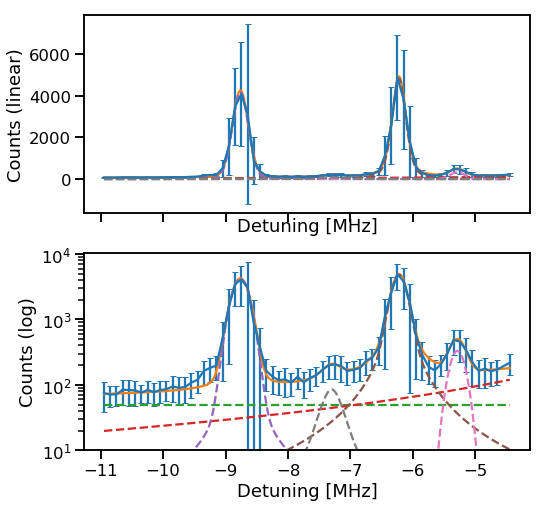

In [16]:
data = pol_data
plot_components = True
plot_initial_guess = False

# Choosing a range to fit over
xmin = -11
xmax = -2

xdata = data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['detuning']
ydata = data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['sfiIntegral_adjusted', 'mean']
ydata_unc = data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['sfiIntegral_adjusted', 'std']

# Specify fit model
bg = PolynomialModel(degree=0, prefix='bg_')
a = PseudoVoigtModel(prefix='a_')
d1 = PseudoVoigtModel(prefix='d1_')
d2 = PseudoVoigtModel(prefix='d2_')
d3 = PseudoVoigtModel(prefix='d3_')
d4 = PseudoVoigtModel(prefix='d4_')
#dx = PseudoVoigtModel(prefix='dx_')

#fit_model = bg + a + d1 + d2 + d3 + d4 + dx
fit_model = bg + a + d1 + d2 + d3 + dx
fit_params = fit_model.make_params()

#fit_params['bg_c0'].set(min(ydata), max=100, vary=True)
fit_params['bg_c0'].set(50, max=100, vary=False)
#fit_params['bg_c1'].set(2, vary=True)
#fit_params['bg_c2'].set(0, vary=True)

fit_params['a_center'].set(0, vary=False)
fit_params['a_amplitude'].set(120226, vary=True)
fit_params['a_sigma'].set(0.1, min=0, vary=True)

fit_params['d1_center'].set(-8.76, vary=True)
fit_params['d1_amplitude'].set(1120, min=0, vary=True)
fit_params['d1_sigma'].set(0.1, min=0, vary=True)

fit_params['dx_center'].set(-7.3, vary=True)
fit_params['dx_amplitude'].set(24, min=0, vary=True)
fit_params['dx_sigma'].set(0.1, min=0, vary=True)

fit_params['d2_center'].set(-6.2, vary=True)
fit_params['d2_amplitude'].set(1172, min=0, vary=True)
fit_params['d2_sigma'].set(0.1, min=0, vary=True)

fit_params['d3_center'].set(-5.25, vary=True)
fit_params['d3_amplitude'].set(70, min=0, vary=True)
fit_params['d3_sigma'].set(0.1, min=0, vary=True)

#fit_params['d4_center'].set(-4.5, vary=True)
#fit_params['d4_amplitude'].set(140, min=0, vary=True)
#fit_params['d4_sigma'].set(0.1, min=0, vary=True)

# Initial guess
xfit = np.linspace(min(xdata), max(xdata), num=1000, endpoint=True)
yinit = fit_model.eval(fit_params, x=xfit)

# Fitting
fit_result = fit_model.fit(ydata, fit_params, x=xdata)
dely = fit_result.eval_uncertainty(x=xdata)
yfit = fit_model.eval(fit_result.params, x=xfit)

print(fit_result.fit_report())

# Plotting output
[fig, axs] = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False, figsize=(8,8))

axs[0].errorbar(xdata, ydata, yerr=ydata_unc, capsize=3, label='data')
axs[0].plot(xfit, yfit, label='fit')
axs[0].set_xlabel('Detuning [MHz]')
axs[0].set_ylabel('Counts (linear)')

axs[1].set_yscale('log')
axs[1].errorbar(xdata, ydata, yerr=ydata_unc, capsize=3, label='data')
axs[1].plot(xfit, yfit, label='fit')
axs[1].set_xlabel('Detuning [MHz]')
axs[1].set_ylabel('Counts (log)')
axs[1].set_ylim(bottom=10)

if plot_components:
    # generate components
    fit_comps = fit_result.eval_components(x=xfit)
    
    for key in fit_comps.keys():
        for ax in axs:
            ax.plot(xfit, fit_comps[key], '--')

if plot_initial_guess:
    for ax in axs:
        ax.plot(xfit, yinit, '-.', label='init')

plt.show()

In [17]:
# Extracting the fitted parameters

labview_params = [('numberAtom', 'mean'), ('tempXAtom', 'mean'), ('tempYAtom', 'mean'), ('UV_Power', 'mean'), ('Spec_Power', 'mean')]

print('Xmin [MHz]:\t' + str(min(xdata)))
print('Xmax [MHz]:\t' + str(max(xdata)))
for p in labview_params:
    print(p[0] + '(mean):\t' + str(np.mean(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)][p])))
    print(p[0] + '(std):\t' + str(np.std(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)][p])))

# Saving to variables
d1_pol_int = ufloat(fit_result.params['d1_amplitude'].value, fit_result.params['d1_amplitude'].stderr)
d1_pol_N = ufloat(np.mean(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['numberAtom', 'mean']),
                  np.std(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['numberAtom', 'mean']))
d1_pol_Tx = ufloat(np.mean(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['tempXAtom', 'mean']),
                   np.std(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['tempXAtom', 'mean']))
d1_pol_Ty = ufloat(np.mean(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['tempYAtom', 'mean']),
                   np.std(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['tempYAtom', 'mean']))

d2_pol_int = ufloat(fit_result.params['d2_amplitude'].value, fit_result.params['d2_amplitude'].stderr)
d2_pol_N = d1_pol_N
d2_pol_Tx = d1_pol_Tx
d2_pol_Ty = d1_pol_Ty

Xmin [MHz]:	-10.946780000000217
Xmax [MHz]:	-4.446780000000217
numberAtom(mean):	226915.8359798106
numberAtom(std):	4416.462317862592
tempXAtom(mean):	8.077427827451479e-07
tempXAtom(std):	7.3935631747091145e-09
tempYAtom(mean):	7.686944671179947e-07
tempYAtom(std):	6.3229563743003826e-09
UV_Power(mean):	0.5936544150475147
UV_Power(std):	0.006073829806840086
Spec_Power(mean):	0.46401475269643505
Spec_Power(std):	0.0007276679065127743


### n=34, unpolarized sample

#### n=34, unpolarized, dimer, ground state

[[Model]]
    ((Model(polynomial, prefix='bg_') + Model(pvoigt, prefix='d0_')) + Model(pvoigt, prefix='dx_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 252
    # data points      = 28
    # variables        = 8
    chi-square         = 19085.8707
    reduced chi-square = 954.293536
    Akaike info crit   = 198.685974
    Bayesian info crit = 209.343610
[[Variables]]
    bg_c0:         4.78715945 +/- 14.4617543 (302.09%) (init = 10.86863)
    d0_fraction:   0.38657910 +/- 0.20577537 (53.23%) (init = 0.5)
    d0_sigma:      0.16043345 +/- 0.00730130 (4.55%) (init = 0.1)
    d0_center:    -20.0413187 +/- 0.00490891 (0.02%) (init = -20)
    d0_amplitude:  350.965079 +/- 28.0151823 (7.98%) (init = 537)
    dx_fraction:   0.99999988 +/- 3.94146732 (394.15%) (init = 0.5)
    dx_sigma:      0.19999998 +/- 0.33650444 (168.25%) (init = 0.1)
    dx_center:    -19.4 (fixed)
    dx_amplitude:  19.3287273 +/- 43.4197120 (224.64%) (init = 43)
    d0_fwhm:       0.32

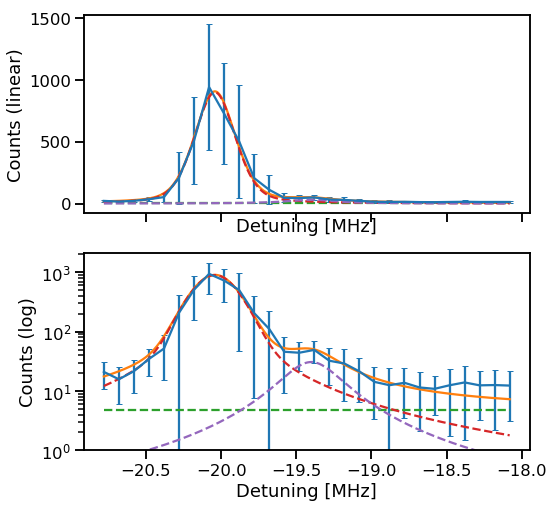

In [18]:
data = unpol_data
plot_components = True
plot_initial_guess = False

# Choosing a range to fit over
xmin = -23
xmax = -18

xdata = data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['detuning']
ydata = data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['sfiIntegral_adjusted', 'mean']
ydata_unc = data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['sfiIntegral_adjusted', 'std']

# Specify fit model
bg = PolynomialModel(degree=0, prefix='bg_')
d0 = PseudoVoigtModel(prefix='d0_')
dx = PseudoVoigtModel(prefix='dx_')

fit_model = bg + d0 + dx
#fit_model = bg + d0
fit_params = fit_model.make_params()

fit_params['bg_c0'].set(min(ydata), vary=True)
#fit_params['bg_c1'].set(0, vary=True)
#fit_params['bg_c2'].set(0, vary=True)

fit_params['d0_center'].set(-20, vary=True)
fit_params['d0_amplitude'].set(537, min=0, vary=True)
fit_params['d0_sigma'].set(0.1, min=0, vary=True)

fit_params['dx_center'].set(-19.4, min=-19.5, vary=False)
fit_params['dx_amplitude'].set(43, min=0, vary=True)
fit_params['dx_sigma'].set(0.1, min=0, max=0.2, vary=True)

# Initial guess
xfit = np.linspace(min(xdata), max(xdata), num=1000, endpoint=True)
yinit = fit_model.eval(fit_params, x=xfit)

# Fitting
fit_result = fit_model.fit(ydata, fit_params, x=xdata)
dely = fit_result.eval_uncertainty(x=xdata)
yfit = fit_model.eval(fit_result.params, x=xfit)

print(fit_result.fit_report())

# Plotting output
[fig, axs] = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False, figsize=(8,8))

axs[0].errorbar(xdata, ydata, yerr=ydata_unc, capsize=3, label='data')
axs[0].plot(xfit, yfit, label='fit')
axs[0].set_xlabel('Detuning [MHz]')
axs[0].set_ylabel('Counts (linear)')

axs[1].set_yscale('log')
axs[1].errorbar(xdata, ydata, yerr=ydata_unc, capsize=3, label='data')
axs[1].plot(xfit, yfit, label='fit')
axs[1].set_xlabel('Detuning [MHz]')
axs[1].set_ylabel('Counts (log)')
axs[1].set_ylim(bottom=1)

if plot_components:
    # generate components
    fit_comps = fit_result.eval_components(x=xfit)
    
    for key in fit_comps.keys():
        for ax in axs:
            ax.plot(xfit, fit_comps[key], '--')

if plot_initial_guess:
    for ax in axs:
        ax.plot(xfit, yinit, '-.', label='init')

plt.show()

In [19]:
# Extracting the fitted parameters

labview_params = [('numberAtom', 'mean'), ('tempXAtom', 'mean'), ('tempYAtom', 'mean'), ('UV_Power', 'mean'), ('Spec_Power', 'mean')]

print('Xmin [MHz]:\t' + str(min(xdata)))
print('Xmax [MHz]:\t' + str(max(xdata)))
for p in labview_params:
    print(p[0] + '(mean):\t' + str(np.mean(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)][p])))
    print(p[0] + '(std):\t' + str(np.std(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)][p])))

# Saving to variables
d0_unpol_int = ufloat(fit_result.params['d0_amplitude'].value, fit_result.params['d0_amplitude'].stderr)
d0_unpol_N = ufloat(np.mean(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['numberAtom', 'mean']),
                    np.std(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['numberAtom', 'mean']))
d0_unpol_Tx = ufloat(np.mean(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['tempXAtom', 'mean']),
                     np.std(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['tempXAtom', 'mean']))
d0_unpol_Ty = ufloat(np.mean(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['tempYAtom', 'mean']),
                     np.std(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['tempYAtom', 'mean']))

d0_unpol_height = ufloat(fit_result.params['d0_height'].value, fit_result.params['d0_height'].stderr)

Xmin [MHz]:	-20.779999999999745
Xmax [MHz]:	-18.079999999999927
numberAtom(mean):	215125.35114108803
numberAtom(std):	4001.7504395278065
tempXAtom(mean):	9.964611509343212e-07
tempXAtom(std):	1.0749130571111205e-08
tempYAtom(mean):	8.600807191563468e-07
tempYAtom(std):	5.064645397669494e-09
UV_Power(mean):	0.5962146969592345
UV_Power(std):	0.004079752694828221
Spec_Power(mean):	0.465497392454489
Spec_Power(std):	0.0006175933501823958


#### n=34, unpolarized, dimer, 1st and 2nd excited states

[[Model]]
    (((((Model(polynomial, prefix='bg_') + Model(pvoigt, prefix='a_')) + Model(pvoigt, prefix='d1_')) + Model(pvoigt, prefix='d2_')) + Model(pvoigt, prefix='d3_')) + Model(pvoigt, prefix='d4_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 942
    # data points      = 80
    # variables        = 20
    chi-square         = 8218.63476
    reduced chi-square = 136.977246
    Akaike info crit   = 410.570620
    Bayesian info crit = 458.211153
[[Variables]]
    bg_c0:         10.9611484 +/- 4.71913267 (43.05%) (init = 50)
    a_fraction:    0.31039930 +/- 613352.366 (197601080.04%) (init = 0.5)
    a_sigma:       0.03188362 +/- 40.1717626 (125994.97%) (init = 0.1)
    a_center:      0 (fixed)
    a_amplitude:   73628.7645 +/- 1.4550e+11 (197608706.61%) (init = 120226)
    d1_fraction:   0.30705583 +/- 0.10472818 (34.11%) (init = 0.5)
    d1_sigma:      0.15517768 +/- 0.00347834 (2.24%) (init = 0.1)
    d1_center:    -8.79624498 +/- 0.00245290 (0.03

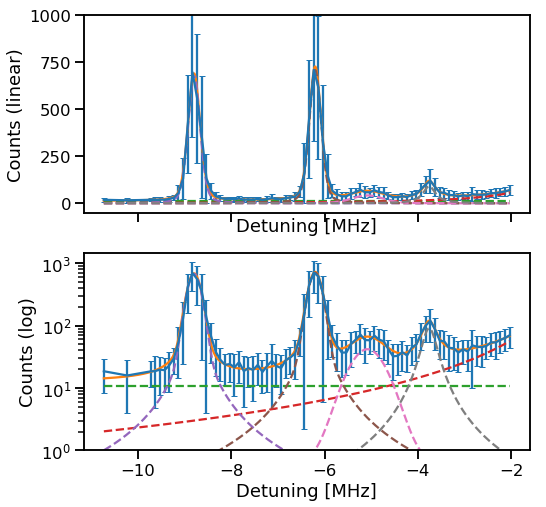

In [20]:
data = unpol_data
plot_components = True
plot_initial_guess = False

# Choosing a range to fit over
xmin = -11
xmax = -2

xdata = data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['detuning']
ydata = data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['sfiIntegral_adjusted', 'mean']
ydata_unc = data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['sfiIntegral_adjusted', 'std']

# Specify fit model
bg = PolynomialModel(degree=0, prefix='bg_')
a = PseudoVoigtModel(prefix='a_')
d1 = PseudoVoigtModel(prefix='d1_')
d2 = PseudoVoigtModel(prefix='d2_')
d3 = PseudoVoigtModel(prefix='d3_')
d4 = PseudoVoigtModel(prefix='d4_')

fit_model = bg + a + d1 + d2 + d3 + d4
fit_params = fit_model.make_params()

#fit_params['bg_c0'].set(min(ydata), max=100, vary=True)
fit_params['bg_c0'].set(50, max=100, vary=True)
#fit_params['bg_c1'].set(2, vary=True)
#fit_params['bg_c2'].set(0, vary=True)

fit_params['a_center'].set(0, vary=False)
fit_params['a_amplitude'].set(120226, vary=True)
fit_params['a_sigma'].set(0.1, min=0, vary=True)

fit_params['d1_center'].set(-8.76, vary=True)
fit_params['d1_amplitude'].set(1120, min=0, vary=True)
fit_params['d1_sigma'].set(0.1, min=0, vary=True)

fit_params['d2_center'].set(-6.22, vary=True)
fit_params['d2_amplitude'].set(1172, min=0, vary=True)
fit_params['d2_sigma'].set(0.1, min=0, vary=True)

fit_params['d3_center'].set(-5.28, vary=True)
fit_params['d3_amplitude'].set(70, min=0, vary=True)
fit_params['d3_sigma'].set(0.1, min=0, vary=True)

fit_params['d4_center'].set(-4, vary=True)
fit_params['d4_amplitude'].set(140, min=0, vary=True)
fit_params['d4_sigma'].set(0.1, min=0, vary=True)

# Initial guess
xfit = np.linspace(min(xdata), max(xdata), num=1000, endpoint=True)
yinit = fit_model.eval(fit_params, x=xfit)

# Fitting
fit_result = fit_model.fit(ydata, fit_params, x=xdata)
dely = fit_result.eval_uncertainty(x=xdata)
yfit = fit_model.eval(fit_result.params, x=xfit)

print(fit_result.fit_report())

# Plotting output
[fig, axs] = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False, figsize=(8,8))

axs[0].errorbar(xdata, ydata, yerr=ydata_unc, capsize=3, label='data')
axs[0].plot(xfit, yfit, label='fit')
axs[0].set_xlabel('Detuning [MHz]')
axs[0].set_ylabel('Counts (linear)')
axs[0].set_ylim(top=1000)

axs[1].set_yscale('log')
axs[1].errorbar(xdata, ydata, yerr=ydata_unc, capsize=3, label='data')
axs[1].plot(xfit, yfit, label='fit')
axs[1].set_xlabel('Detuning [MHz]')
axs[1].set_ylabel('Counts (log)')
axs[1].set_ylim(bottom=1)

if plot_components:
    # generate components
    fit_comps = fit_result.eval_components(x=xfit)
    
    for key in fit_comps.keys():
        for ax in axs:
            ax.plot(xfit, fit_comps[key], '--')

if plot_initial_guess:
    for ax in axs:
        ax.plot(xfit, yinit, '-.', label='init')

plt.show()

In [21]:
# Extracting the fitted parameters

labview_params = [('numberAtom', 'mean'), ('tempXAtom', 'mean'), ('tempYAtom', 'mean'), ('UV_Power', 'mean'), ('Spec_Power', 'mean')]

print('Xmin [MHz]:\t' + str(min(xdata)))
print('Xmax [MHz]:\t' + str(max(xdata)))
for p in labview_params:
    print(p[0] + '(mean):\t' + str(np.mean(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)][p])))
    print(p[0] + '(std):\t' + str(np.std(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)][p])))

# Saving to variables
d1_unpol_int = ufloat(fit_result.params['d1_amplitude'].value, fit_result.params['d1_amplitude'].stderr)
d1_unpol_N = ufloat(np.mean(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['numberAtom', 'mean']),
                  np.std(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['numberAtom', 'mean']))
d1_unpol_Tx = ufloat(np.mean(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['tempXAtom', 'mean']),
                   np.std(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['tempXAtom', 'mean']))
d1_unpol_Ty = ufloat(np.mean(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['tempYAtom', 'mean']),
                   np.std(data[(xmin <= data['detuning']) & (data['detuning'] <= xmax)]['tempYAtom', 'mean']))

d2_unpol_int = ufloat(fit_result.params['d2_amplitude'].value, fit_result.params['d2_amplitude'].stderr)
d2_unpol_N = d1_unpol_N
d2_unpol_Tx = d1_unpol_Tx
d2_unpol_Ty = d1_unpol_Ty

Xmin [MHz]:	-10.730000000000018
Xmax [MHz]:	-2.0299999999997453
numberAtom(mean):	219344.8153837234
numberAtom(std):	3563.010406184859
tempXAtom(mean):	9.94576884697456e-07
tempXAtom(std):	9.584410477617168e-09
tempYAtom(mean):	8.592819219318295e-07
tempYAtom(std):	6.066941993710516e-09
UV_Power(mean):	0.5962370472187819
UV_Power(std):	0.0044642111618143614
Spec_Power(mean):	0.46486171260038434
Spec_Power(std):	0.0007115894139212488


# Some uncertainty calculations

In [22]:
d0_pol_int_corr = d0_pol_int/(d0_pol_N**2/d0_pol_Ty**(3/2))
d1_pol_int_corr = d1_pol_int/(d1_pol_N**2/d1_pol_Ty**(3/2))
d2_pol_int_corr = d2_pol_int/(d2_pol_N**2/d2_pol_Ty**(3/2))

d0_unpol_int_corr = d0_unpol_int/(d0_unpol_N**2/d0_unpol_Ty**(3/2))
d1_unpol_int_corr = d1_unpol_int/(d1_unpol_N**2/d1_unpol_Ty**(3/2))
d2_unpol_int_corr = d2_unpol_int/(d2_unpol_N**2/d2_unpol_Ty**(3/2))

In [23]:
d1_pol_int_corr/d0_pol_int_corr
d2_pol_int_corr/d0_pol_int_corr

d1_unpol_int_corr/d0_unpol_int_corr
d2_unpol_int_corr/d0_unpol_int_corr

0.7036155721307165+/-0.07512977529828566

### Correcting for Tx and Ty (2019/04/24)

In [24]:
d0_pol_int_corr = d0_pol_int/(d0_pol_N**2/(d0_pol_Tx*d0_pol_Ty**(1/2)))
d1_pol_int_corr = d1_pol_int/(d1_pol_N**2/(d1_pol_Tx*d1_pol_Ty**(1/2)))
d2_pol_int_corr = d2_pol_int/(d2_pol_N**2/(d2_pol_Tx*d2_pol_Ty**(1/2)))

d0_unpol_int_corr = d0_unpol_int/(d0_unpol_N**2/(d0_unpol_Tx*d0_unpol_Ty**(1/2)))
d1_unpol_int_corr = d1_unpol_int/(d1_unpol_N**2/(d1_unpol_Tx*d1_unpol_Ty**(1/2)))
d2_unpol_int_corr = d2_unpol_int/(d2_unpol_N**2/(d2_unpol_Tx*d2_unpol_Ty**(1/2)))

In [25]:
d1_pol_int_corr/d0_pol_int_corr
d2_pol_int_corr/d0_pol_int_corr

d1_unpol_int_corr/d0_unpol_int_corr
d2_unpol_int_corr/d0_unpol_int_corr

0.7029379159463571+/-0.07518955903461341

In [26]:
print('Dimer ratios for checking')
print(d1_pol_int_corr/d0_pol_int_corr)
print(d2_pol_int_corr/d0_pol_int_corr)

print(d1_unpol_int_corr/d0_unpol_int_corr)
print(d2_unpol_int_corr/d0_unpol_int_corr)

Dimer ratios for checking
0.61+/-0.05
0.71+/-0.06
0.68+/-0.07
0.70+/-0.08


In [27]:
d0_pol_height

6407.086627024615+/-63.857982358532546

In [28]:
d0_unpol_height

899.5153110325814+/-31.184091124291136